0   2001-01-02 20:00:00
1   2001-01-03 00:00:00
2   2001-01-03 04:00:00
3   2001-01-03 08:00:00
4   2001-01-03 12:00:00
Name: datetime, dtype: datetime64[ns]
['datetime', 'open', 'high', 'low', 'close', 'volume', 'pair']


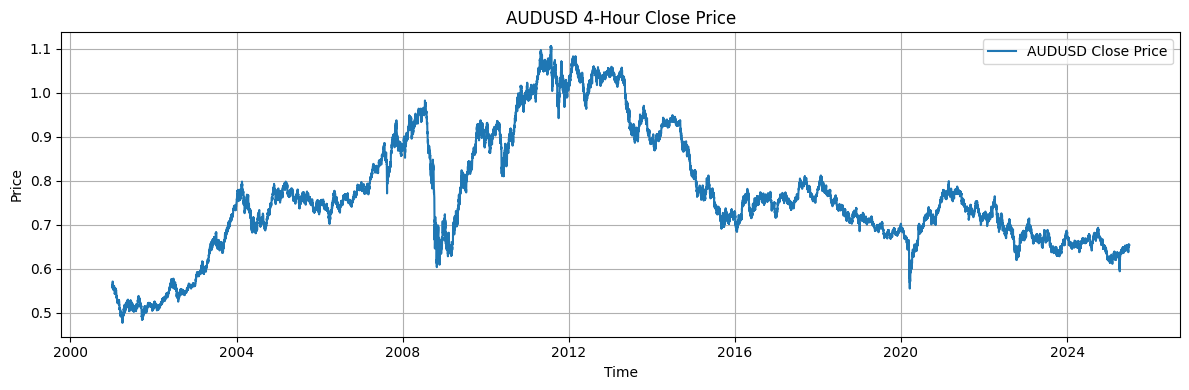

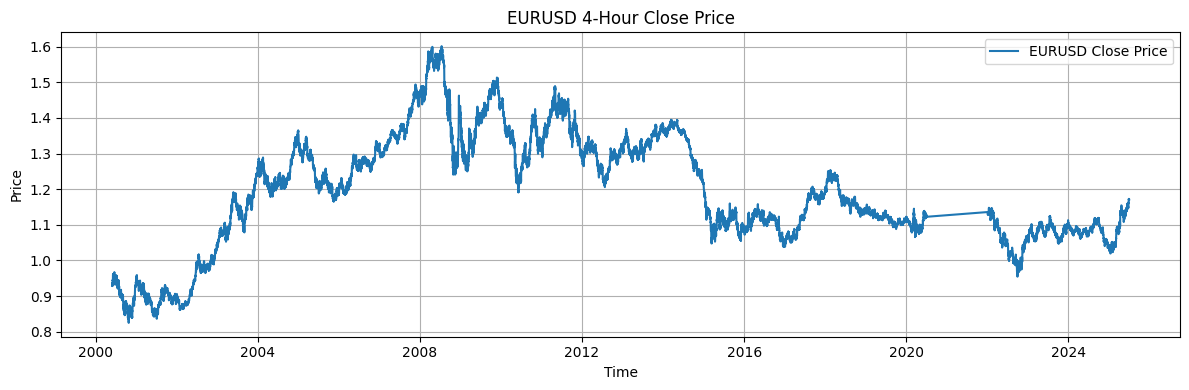

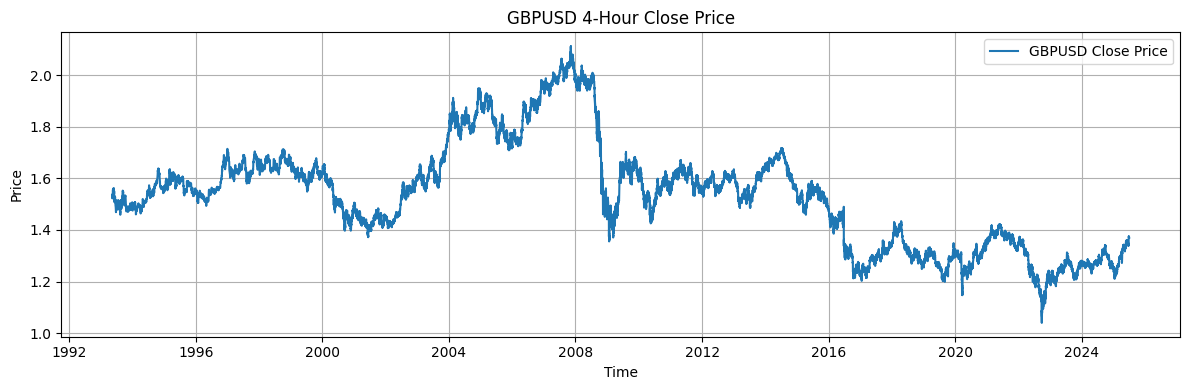

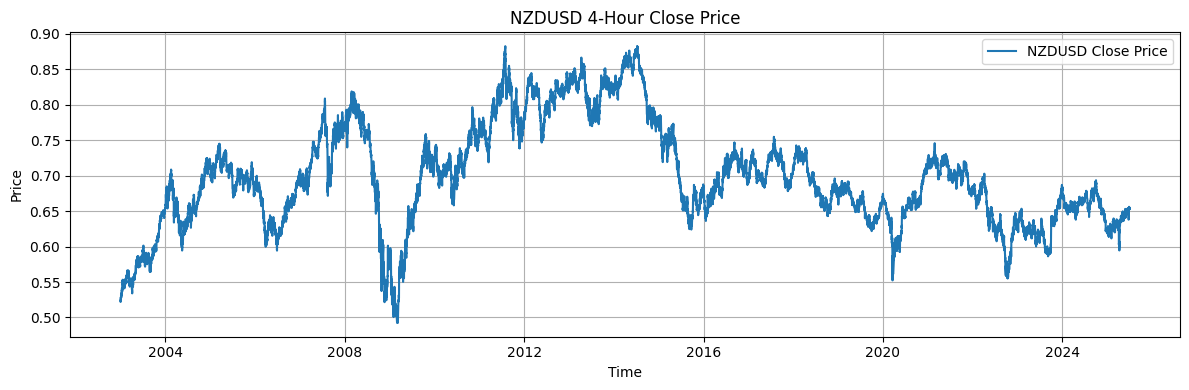

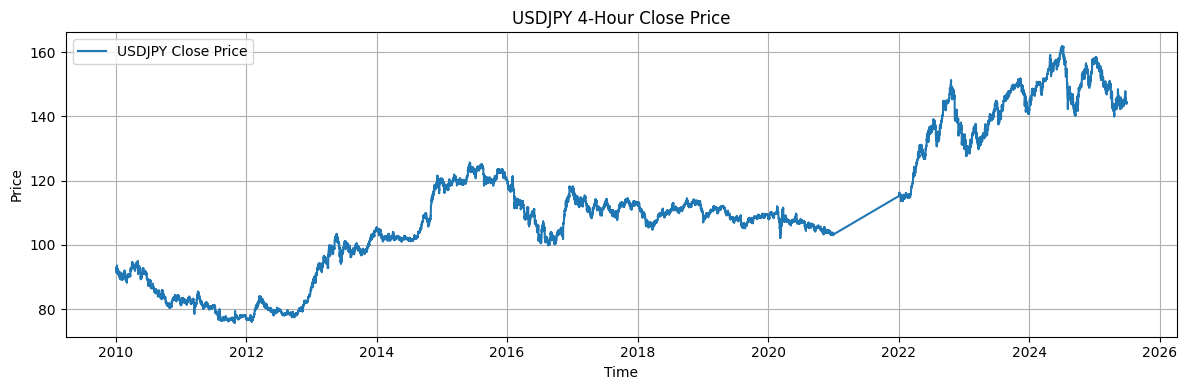

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("all_currencies_combined.csv")
df.columns = df.columns.str.strip().str.lower()

# Convert datetime
df['datetime'] = pd.to_datetime(df['datetime'])

print(df['datetime'].head())
print(df.columns.tolist())

# Plot each currency pair separately
for pair in df['pair'].unique():
    sub_df = df[df['pair'] == pair]

    plt.figure(figsize=(12, 4))
    plt.plot(sub_df['datetime'], sub_df['close'], label=f'{pair} Close Price')
    plt.title(f'{pair} 4-Hour Close Price')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

df = pd.read_csv("all_currencies_combined.csv")
df.columns = df.columns.str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['datetime'])

sequence_length = 60

X_lstm_all = []
y_lstm_all = []
xgb_frames = []

for pair in df['pair'].unique():
    pair_df = df[df['pair'] == pair].copy()
    pair_df.sort_values("datetime", inplace=True)

    # ===== LSTM Preprocessing =====
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(pair_df[['close']])
    
    X_lstm = []
    y_lstm = []

    for i in range(sequence_length, len(scaled_close)):
        X_lstm.append(scaled_close[i - sequence_length:i])
        y_lstm.append(scaled_close[i])  # or scaled_close[i, 0] for consistency

    X_lstm_all.extend(X_lstm)
    y_lstm_all.extend(y_lstm)

    # ===== XGBoost Features =====
    pair_df['return'] = pair_df['close'].pct_change()
    pair_df['lag_1'] = pair_df['close'].shift(1)
    pair_df['lag_2'] = pair_df['close'].shift(2)
    pair_df['lag_3'] = pair_df['close'].shift(3)
    pair_df['hour'] = pair_df['datetime'].dt.hour
    pair_df['minute'] = pair_df['datetime'].dt.minute
    pair_df['pair'] = pair  # ensure 'pair' column is preserved

    pair_df.dropna(inplace=True)
    xgb_frames.append(pair_df)

# === Save LSTM arrays ===
X_lstm_all = np.array(X_lstm_all)
y_lstm_all = np.array(y_lstm_all)

np.save("X_lstm_multicurrency.npy", X_lstm_all)
np.save("y_lstm_multicurrency.npy", y_lstm_all)

# === Save XGBoost-ready dataset ===
df_xgb_all = pd.concat(xgb_frames, ignore_index=True)
df_xgb_all.to_csv("multicurrency_xgb_ready.csv", index=False)

print(f"✅ Saved LSTM arrays: {X_lstm_all.shape}, {y_lstm_all.shape}")
print("✅ Saved XGBoost CSV: multicurrency_xgb_ready.csv")


✅ Saved LSTM arrays: (178664, 60, 1), (178664, 1)
✅ Saved XGBoost CSV: multicurrency_xgb_ready.csv


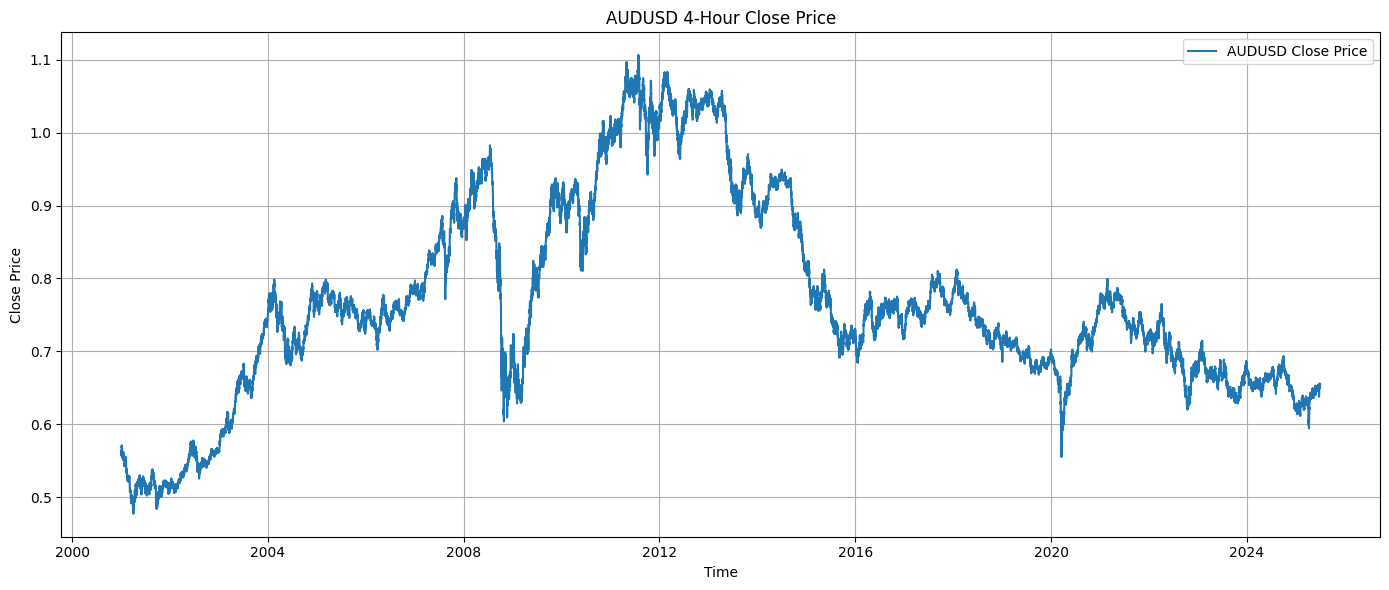

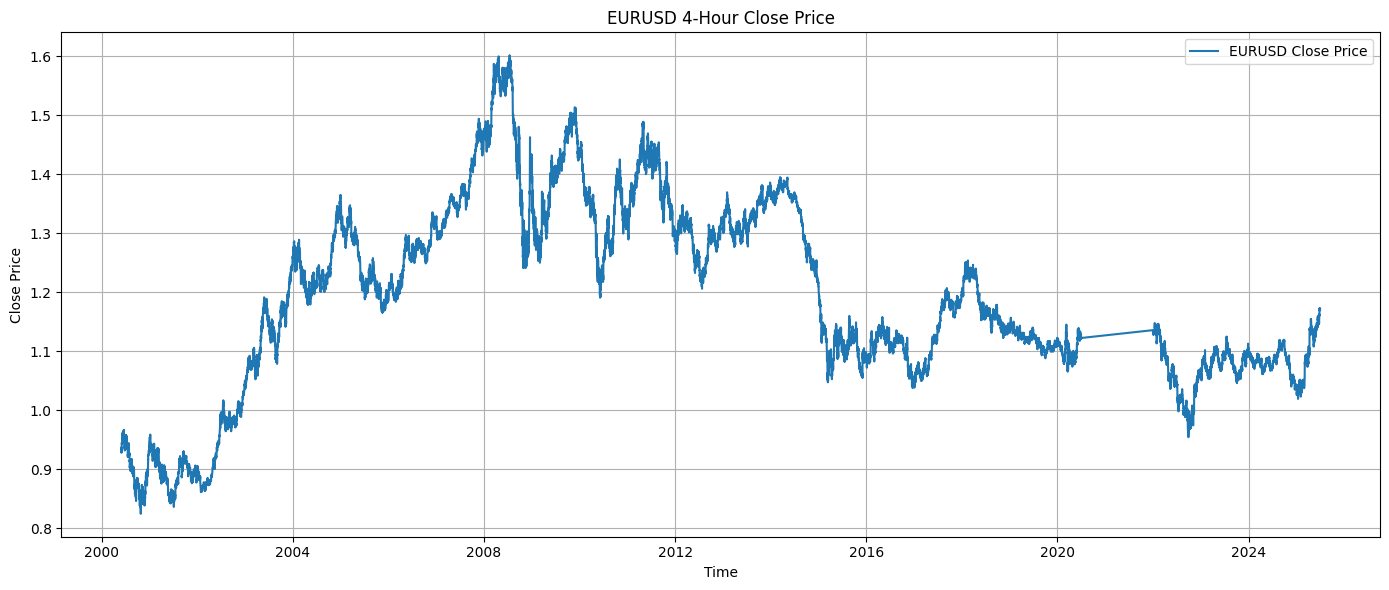

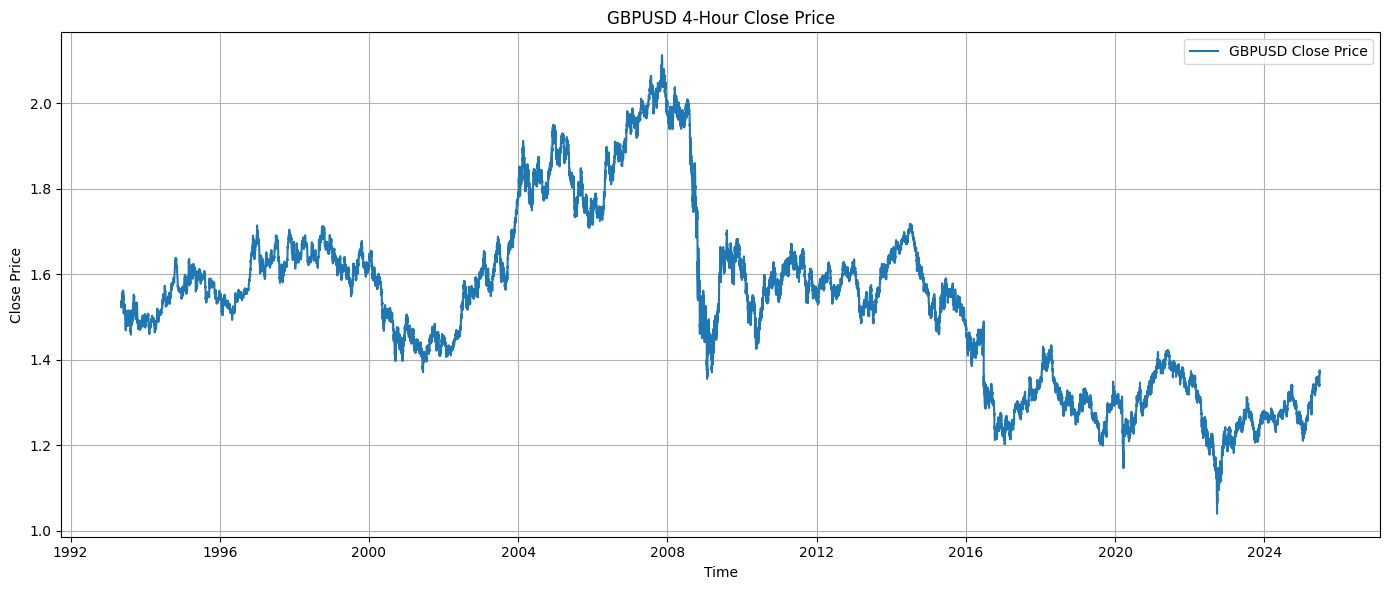

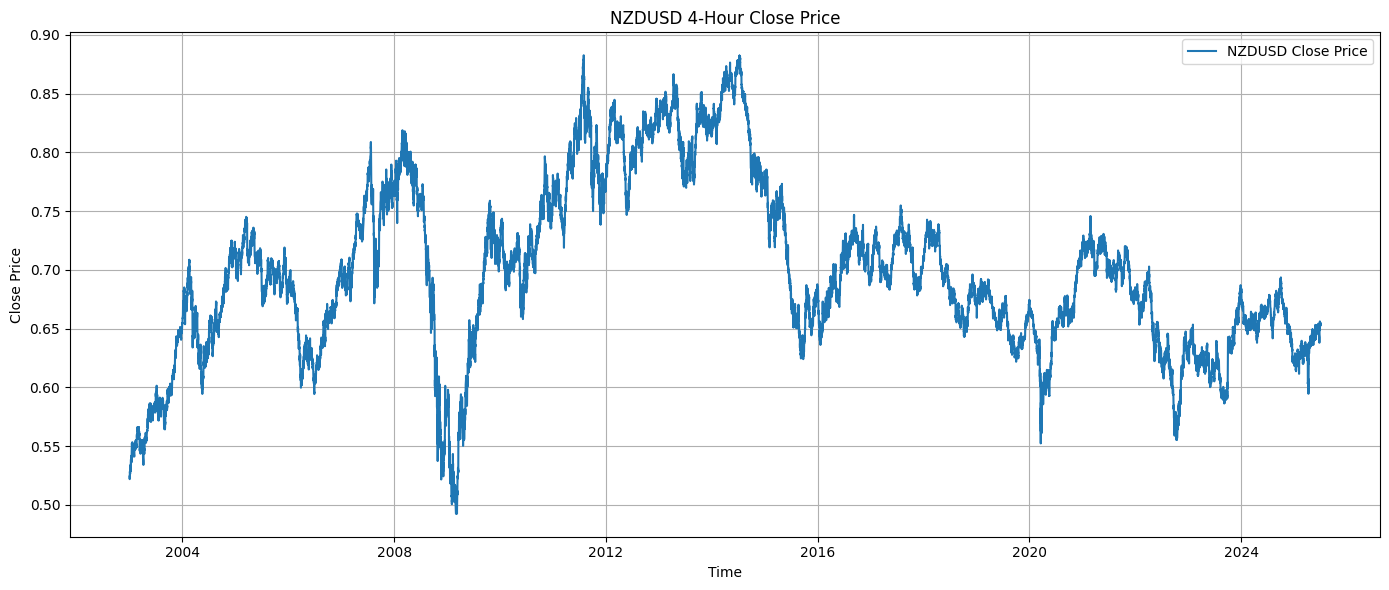

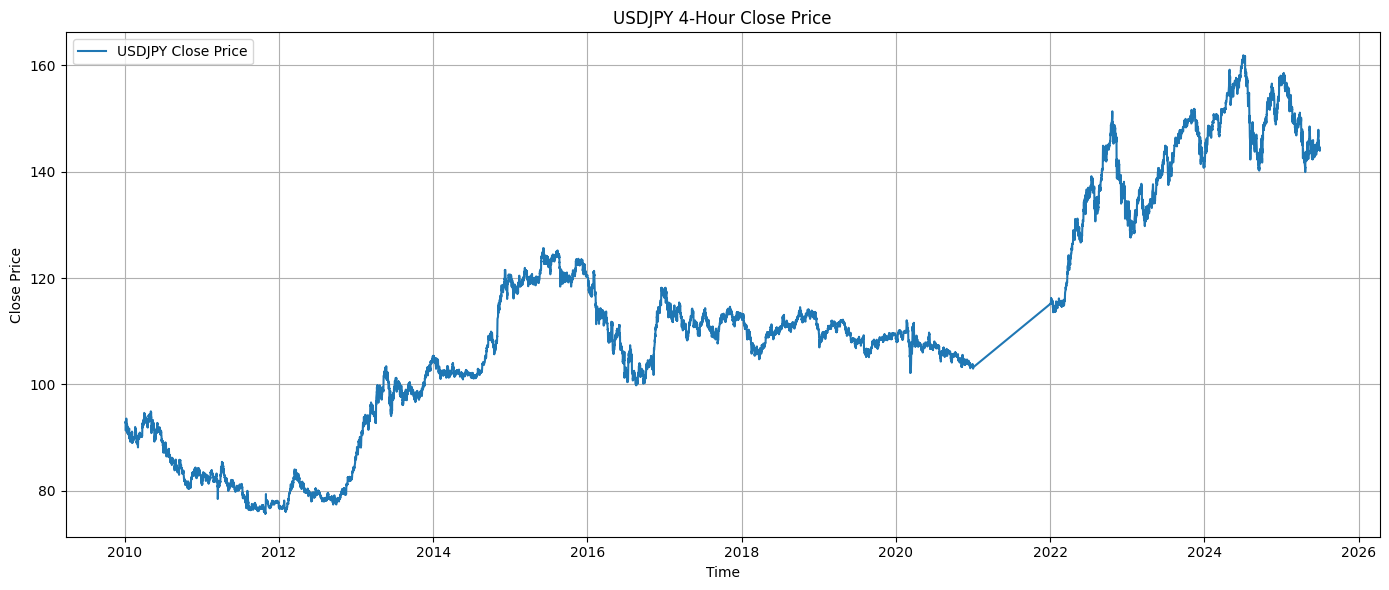

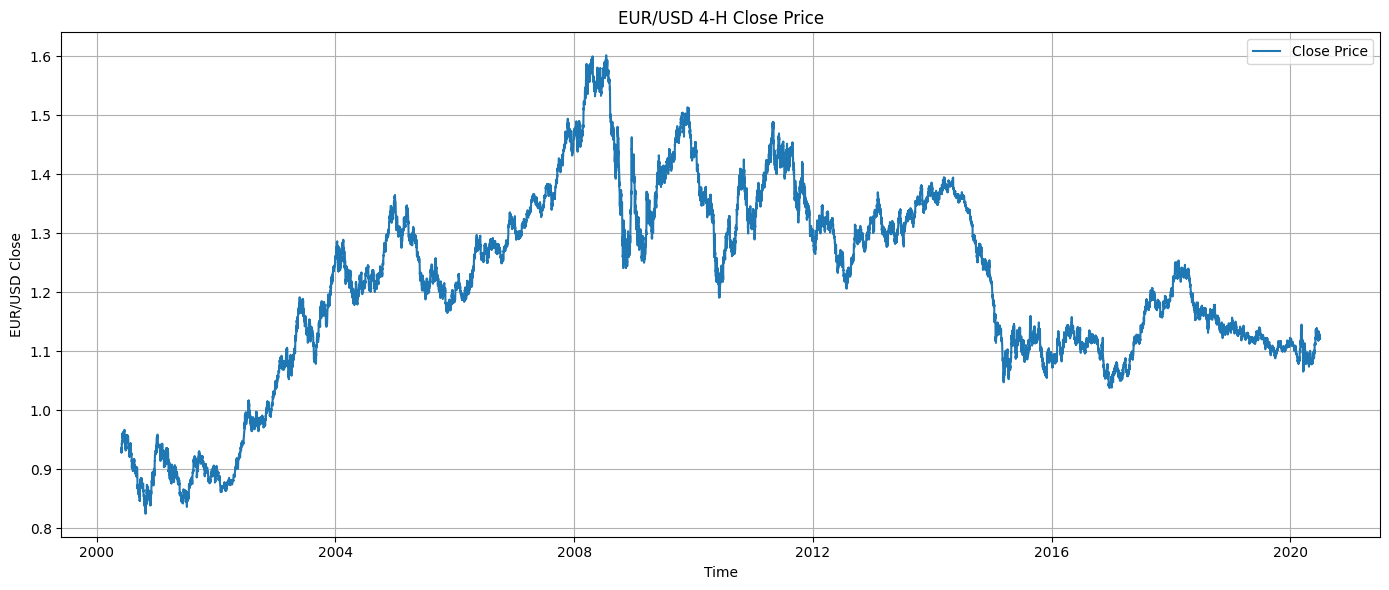

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load multi-currency cleaned dataset
df = pd.read_csv("all_currencies_combined.csv")
df.columns = df.columns.str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['datetime'])

# Plot each currency pair separately
unique_pairs = df['pair'].unique()

for pair in unique_pairs:
    pair_df = df[df['pair'] == pair].sort_values('datetime')

    plt.figure(figsize=(14, 6))
    plt.plot(pair_df['datetime'], pair_df['close'], label=f'{pair} Close Price')
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.title(f"{pair} 4-Hour Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
import pandas as pd
import matplotlib.pyplot as plt

# Load and parse datetime
df = pd.read_csv("eurusd_4hcleaned.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['close'], label='Close Price')
plt.xlabel("Time")
plt.ylabel("EUR/USD Close")
plt.title("EUR/USD 4-H Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

# Load combined OHLCV data
df = pd.read_csv("all_currencies_combined.csv")
df.columns = df.columns.str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['datetime']) + pd.Timedelta(hours=3)

# Loop through each currency pair and plot candlestick chart
for pair in df['pair'].unique():
    pair_df = df[df['pair'] == pair].sort_values('datetime').tail(500)

    fig = go.Figure(data=[go.Candlestick(
        x=pair_df['datetime'],
        open=pair_df['open'],
        high=pair_df['high'],
        low=pair_df['low'],
        close=pair_df['close'],
        name=pair
    )])

    fig.update_layout(
        title=f"{pair} 4-Hour Candlestick Chart",
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False,
        template="plotly_dark",
        height=600
    )

    fig.show()


In [5]:
import pandas as pd
import ta

# Load combined dataset
df = pd.read_csv("all_currencies_combined.csv")
df.columns = df.columns.str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['datetime'])

# Container for processed DataFrames
enriched_dfs = []

# Group by currency pair and apply indicators
for pair, group in df.groupby("pair"):
    group = group.sort_values("datetime").copy()

    # Technical indicators
    group['sma_20'] = ta.trend.sma_indicator(group['close'], window=20)
    group['ema_20'] = ta.trend.ema_indicator(group['close'], window=20)
    group['rsi'] = ta.momentum.rsi(group['close'], window=14)

    group['macd'] = ta.trend.macd(group['close'])
    group['macd_signal'] = ta.trend.macd_signal(group['close'])

    bb = ta.volatility.BollingerBands(close=group['close'], window=20)
    group['bb_upper'] = bb.bollinger_hband()
    group['bb_lower'] = bb.bollinger_lband()
    group['bb_mid'] = bb.bollinger_mavg()

    # Support & resistance
    group['support'] = group['low'].rolling(window=20).min()
    group['resistance'] = group['high'].rolling(window=20).max()

    # Drop rows with NaNs from indicators
    group.dropna(inplace=True)

    enriched_dfs.append(group)

# Combine all processed groups
df_enriched = pd.concat(enriched_dfs, ignore_index=True)

# Save
df_enriched.to_csv("all_currencies_with_indicators.csv", index=False)
print("✅ Enriched multi-currency dataset with indicators saved.")


✅ Enriched multi-currency dataset with indicators saved.


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("all_currencies_with_indicators.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['pair', 'datetime'])

# Features to use
features = ['close', 'sma_20', 'ema_20', 'rsi', 'macd', 'macd_signal']
sequence_length = 60

# Containers
X_all, y_all = [], []

# Group by currency pair
for pair, group in df.groupby("pair"):
    group = group[features].dropna()
    
    # Scale features separately per pair
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(group)

    # Sequence generation
    for i in range(sequence_length, len(scaled)):
        X_all.append(scaled[i - sequence_length:i])
        y_all.append(scaled[i, 0])  # predict 'close'

# Final arrays
X_lstm = np.array(X_all)
y_lstm = np.array(y_all)

# Save to disk
np.save("X_lstm_with_indicators_multi.npy", X_lstm)
np.save("y_lstm_with_indicators_multi.npy", y_lstm)

print(f"✅ Saved LSTM-ready arrays with shape: X={X_lstm.shape}, y={y_lstm.shape}")


✅ Saved LSTM-ready arrays with shape: X=(178499, 60, 6), y=(178499,)


2025-07-12 10:06:30.211380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data shapes: X=(178499, 60, 6), y=(178499,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,265 (200.25 KB)

 Trainable params: 51,265 (200.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 195s 43ms/step - loss: 0.0026 - val_loss: 1.3474e-04
Epoch 2/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 188s 42ms/step - loss: 3.5628e-04 - val_loss: 2.7632e-05
Epoch 3/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 190s 43ms/step - loss: 2.9714e-04 - val_loss: 1.8851e-04
Epoch 4/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 190s 42ms/step - loss: 2.8804e-04 - val_loss: 3.9629e-05
Epoch 5/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 188s 42ms/step - loss: 2.8461e-04 - val_loss: 1.2914e-04
Epoch 6/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 192s 43ms/step - loss: 2.7467e-04 - val_loss: 6.9944e-05
Epoch 7/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 191s 43ms/step - loss: 2.6850e-04 - val_loss: 2.9449e-05
Epoch 8/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 198s 44ms/step - loss: 2.6140e-04 - val_loss: 2.6438e-05
Epoch 9/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 199s 45ms/step - loss: 2.6225e-04 - val_loss: 6.5406e-05
Epoch 10/20
4463/4463 ━━━━━━━━━━━━━━━━━━━━ 198s 44ms/step - loss: 2.5941e-04 - val_loss: 1.1519e-04
Epoch 11/20
4

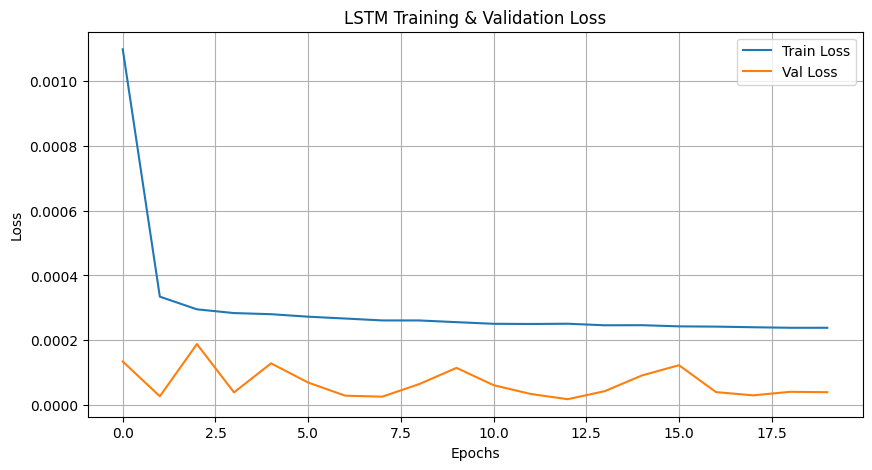

1116/1116 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step
✅ LSTM Test MSE: 0.00004


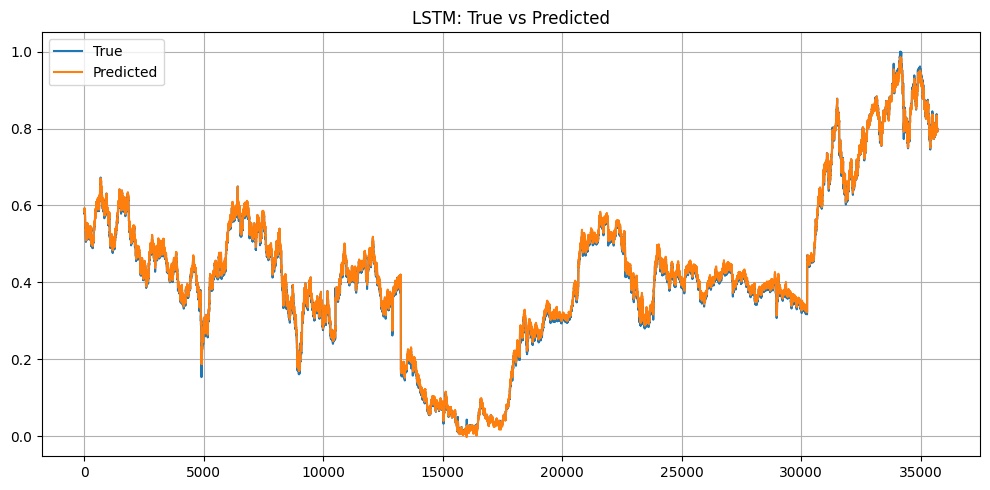

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load multi-currency LSTM sequences
X = np.load("X_lstm_with_indicators_multi.npy")
y = np.load("y_lstm_with_indicators_multi.npy")
print(f"Data shapes: X={X.shape}, y={y.shape}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Model architecture
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Predict & evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"✅ LSTM Test MSE: {mse:.5f}")

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.title("LSTM: True vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save model & predictions
model.save("lstm_model_multi_currency.keras")
np.save("lstm_y_pred_multi.npy", y_pred)


Features: ['sma_20', 'ema_20', 'rsi', 'macd', 'macd_signal']
Target: close

Processing AUDUSD...
AUDUSD - X shape: (38938, 50), y shape: (38938,)
AUDUSD - MSE: 0.000007, MAE: 0.001993, RMSE: 0.002698
AUDUSD - Price range: 0.5945 to 0.7994

Processing EURUSD...
EURUSD - X shape: (37088, 50), y shape: (37088,)
EURUSD - MSE: 0.000013, MAE: 0.002474, RMSE: 0.003542
EURUSD - Price range: 0.9543 to 1.1727

Processing GBPUSD...
GBPUSD - X shape: (44406, 50), y shape: (44406,)
GBPUSD - MSE: 0.000562, MAE: 0.010225, RMSE: 0.023701
GBPUSD - Price range: 1.0399 to 1.4232

Processing NZDUSD...
NZDUSD - X shape: (35812, 50), y shape: (35812,)
NZDUSD - MSE: 0.000005, MAE: 0.001539, RMSE: 0.002179
NZDUSD - Price range: 0.5552 to 0.7458

Processing USDJPY...
USDJPY - X shape: (22505, 50), y shape: (22505,)
USDJPY - MSE: 124.047616, MAE: 9.225923, RMSE: 11.137667
USDJPY - Price range: 127.6060 to 161.8680

=== OVERALL RESULTS ===
Total predictions: 35752
Overall MSE: 15.617126
Overall MAE: 1.165294
Ove

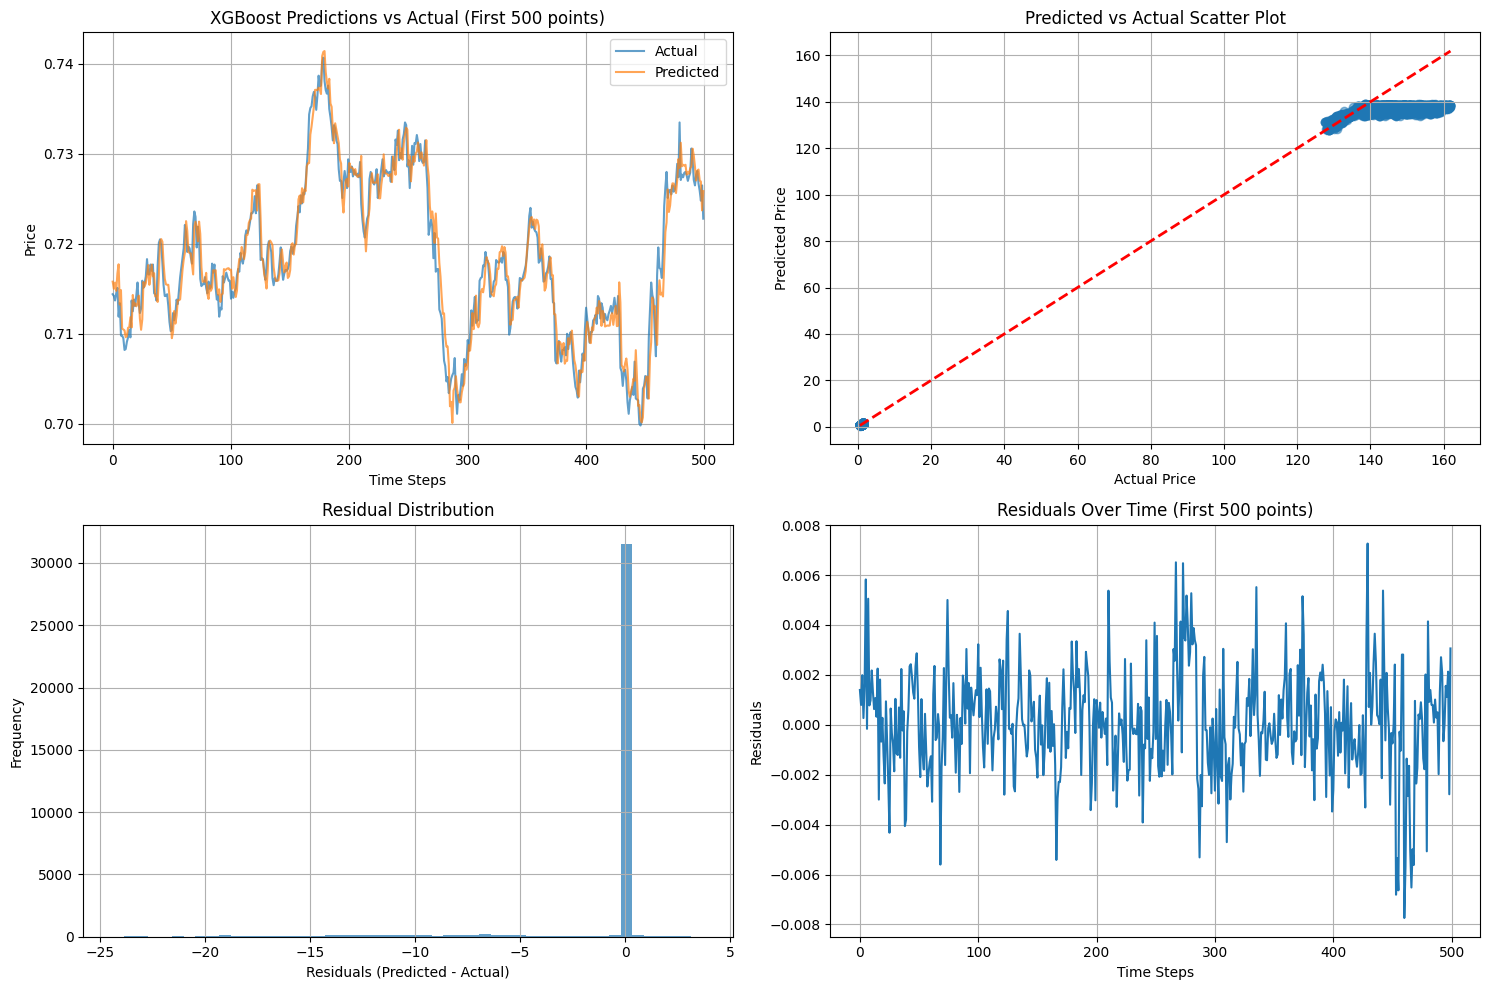


Saved model for AUDUSD

✅ Fixed XGBoost training completed!


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt

# Load and sort dataset
df = pd.read_csv("all_currencies_with_indicators.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['pair', 'datetime'])

# FIXED: Use only technical indicators as features, NOT the target variable
features = ['sma_20', 'ema_20', 'rsi', 'macd', 'macd_signal']  # Removed 'close'
target = 'close'

print(f"Features: {features}")
print(f"Target: {target}")

# Group by currency pair to avoid mixing different scales
all_predictions = []
all_actuals = []
all_models = []

for pair in df['pair'].unique():
    print(f"\nProcessing {pair}...")
    
    # Get data for this pair only
    pair_df = df[df['pair'] == pair].copy()
    pair_df = pair_df[features + [target]].dropna().reset_index(drop=True)
    
    if len(pair_df) < 100:  # Skip pairs with insufficient data
        print(f"Skipping {pair} - insufficient data ({len(pair_df)} rows)")
        continue
    
    # Create lagged features (proper time series approach)
    sequence_length = 10  # Reduced from 60 for better performance
    
    X_sequences = []
    y_targets = []
    
    for i in range(sequence_length, len(pair_df)):
        # Use only technical indicators for features
        feature_seq = pair_df.iloc[i-sequence_length:i][features].values
        X_sequences.append(feature_seq.flatten())  # Flatten the sequence
        y_targets.append(pair_df.iloc[i][target])
    
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    print(f"{pair} - X shape: {X_sequences.shape}, y shape: {y_targets.shape}")
    
    # Train/test split (time series split)
    split_idx = int(len(X_sequences) * 0.8)
    X_train = X_sequences[:split_idx]
    X_test = X_sequences[split_idx:]
    y_train = y_targets[:split_idx]
    y_test = y_targets[split_idx:]
    
    # Scale features (separately for train/test to avoid leakage)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train XGBoost model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42,
        early_stopping_rounds=10
    )
    
    # Train with early stopping
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"{pair} - MSE: {mse:.6f}, MAE: {mae:.6f}, RMSE: {rmse:.6f}")
    print(f"{pair} - Price range: {y_test.min():.4f} to {y_test.max():.4f}")
    
    # Store results
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test)
    all_models.append((pair, model, scaler))

# Overall evaluation
overall_mse = mean_squared_error(all_actuals, all_predictions)
overall_mae = mean_absolute_error(all_actuals, all_predictions)
overall_rmse = np.sqrt(overall_mse)

print(f"\n=== OVERALL RESULTS ===")
print(f"Total predictions: {len(all_predictions)}")
print(f"Overall MSE: {overall_mse:.6f}")
print(f"Overall MAE: {overall_mae:.6f}")
print(f"Overall RMSE: {overall_rmse:.6f}")

# Plot results
plt.figure(figsize=(15, 10))

# Plot 1: Overall predictions vs actual
plt.subplot(2, 2, 1)
plt.plot(all_actuals[:500], label='Actual', alpha=0.7)
plt.plot(all_predictions[:500], label='Predicted', alpha=0.7)
plt.title('XGBoost Predictions vs Actual (First 500 points)')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot 2: Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(all_actuals, all_predictions, alpha=0.5)
plt.plot([min(all_actuals), max(all_actuals)], [min(all_actuals), max(all_actuals)], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Scatter Plot')
plt.grid(True)

# Plot 3: Residuals
residuals = np.array(all_predictions) - np.array(all_actuals)
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Residuals (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True)

# Plot 4: Residuals over time
plt.subplot(2, 2, 4)
plt.plot(residuals[:500])
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.title('Residuals Over Time (First 500 points)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the best model (you can modify this to save all models)
if all_models:
    best_pair, best_model, best_scaler = all_models[0]  # Save first model as example
    joblib.dump(best_model, f"xgboost_model_{best_pair}_fixed.pkl")
    joblib.dump(best_scaler, f"xgboost_scaler_{best_pair}_fixed.pkl")
    print(f"\nSaved model for {best_pair}")

print("\n✅ Fixed XGBoost training completed!") 


1116/1116 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step


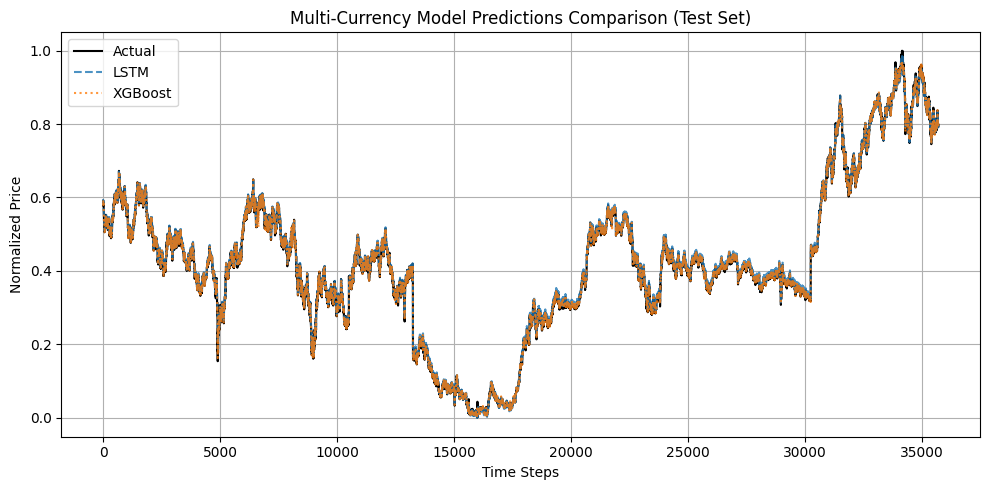

✅ LSTM MSE: 0.00004
✅ XGBoost MSE: 0.00002


In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load multi-currency models
model_lstm = load_model('lstm_model_multi_currency.keras', compile=False)
model_xgb = joblib.load('xgboost_model_multicurrency.pkl')

# Load multi-currency data
X = np.load('X_lstm_with_indicators_multi.npy')  # (samples, 60, 6)
y = np.load('y_lstm_with_indicators_multi.npy')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# LSTM Predictions
pred_lstm = model_lstm.predict(X_test)

# XGBoost Predictions (requires flattening)
X_xgb_test = X_test.reshape(X_test.shape[0], -1)
pred_xgb = model_xgb.predict(X_xgb_test)

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", color='black')
plt.plot(pred_lstm, label="LSTM", linestyle='dashed', alpha=0.8)
plt.plot(pred_xgb, label="XGBoost", linestyle='dotted', alpha=0.8)
plt.title("Multi-Currency Model Predictions Comparison (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print errors
mse_lstm = mean_squared_error(y_test, pred_lstm)
mse_xgb = mean_squared_error(y_test, pred_xgb)
print(f"✅ LSTM MSE: {mse_lstm:.5f}")
print(f"✅ XGBoost MSE: {mse_xgb:.5f}")


5586/5586 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step


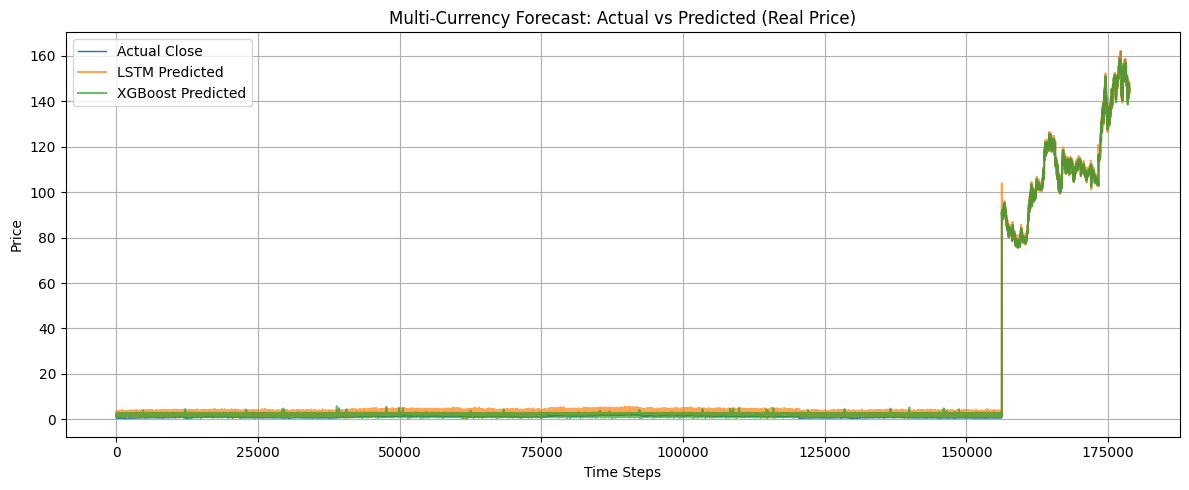

✅ Real LSTM MSE: 3.92345
✅ Real XGBoost MSE: 1.22664


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from lstm_predictor import get_lstm_predictions
from xgb_predictor import get_xgb_predictions
import importlib
import lstm_predictor
importlib.reload(lstm_predictor)

# Load dataset with indicators
df = pd.read_csv("all_currencies_with_indicators.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
features = ['close', 'sma_20', 'ema_20', 'rsi', 'macd', 'macd_signal']

# Get LSTM predictions and scaler
lstm_preds, X_lstm, scaler = get_lstm_predictions("lstm_model.keras", df, features)

# Get XGBoost predictions
xgb_preds, X_xgb = get_xgb_predictions("xgboost_model_multicurrency.pkl", df)

# Prepare true values for comparison (aligned with preds)
df_clean = df[features].dropna().reset_index(drop=True)
y_true = df_clean['close'].values[60:]  # match LSTM output length

# === Inverse transform predictions ===
# Step 1: Pad predictions to match scaler input shape
def inverse_transform(preds_1d, scaler, features):
    padded = np.concatenate([preds_1d.reshape(-1, 1), np.zeros((len(preds_1d), len(features)-1))], axis=1)
    return scaler.inverse_transform(padded)[:, 0]  # Only extract the inverse of 'close'

lstm_preds_real = inverse_transform(lstm_preds, scaler, features)
xgb_preds_real = inverse_transform(xgb_preds, scaler, features)

# Now MSE in real price space
mse_lstm = mean_squared_error(y_true, lstm_preds_real)
mse_xgb = mean_squared_error(y_true, xgb_preds_real)

# === Plot ===
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Actual Close', linewidth=1)
plt.plot(lstm_preds_real, label='LSTM Predicted', alpha=0.7)
plt.plot(xgb_preds_real, label='XGBoost Predicted', alpha=0.7)
plt.title("Multi-Currency Forecast: Actual vs Predicted (Real Price)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results
print(f"✅ Real LSTM MSE: {mse_lstm:.5f}")
print(f"✅ Real XGBoost MSE: {mse_xgb:.5f}")


